# Data processing

In [96]:
import matplotlib   
%matplotlib inline
from matplotlib import pyplot as plt

import itertools
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas import datetime
import seaborn as sns 
import multiprocessing
import math                 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error #for calculation
!pip install yfinance # We install and import yfinance to get the data of stocks through yahoo servers
import yfinance as yf
import plotly.graph_objects as go
from datetime import date, datetime, timedelta
from pylab import rcParams 
from tqdm import tqdm_notebook

 #importation of model Prophet from facebook Data Scientists Core Team
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

from statsmodels.tsa.arima_model import ARIMA

# import for lstm 
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Constant

In [97]:
H = 21                    # Forecast Horizon
TRAIN_SIZE = 503        # 2 years of training. There are approximately 252 trading days in a year. Use 2 years of data as train

## Loss Functions

In [98]:
# Loss Functions

def mape_calc(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae_calc(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def rmse_calc(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def r2_calc (a, b):
    """
    Comp R^2. a and b can be lists.
    Returns a scalar.
    """
    return r2_score(a, b)


## Looking at the data

In [99]:
# Read stock prices from yahoo oracle
company="AAPL"
stocks = yf.Ticker(company)
df=stocks.history(start='2017-01-01', end='2022-01-01', actions=False)
df = df.reset_index()

# Sort Ascending
df.sort_values(by='Date', inplace=True, ascending=True)

# Data Length
print("Data Length : " + str(len(df)))

df.head(10)

Data Length : 1259


,Date,Open,High,Low,Close,Volume
0,2017-01-03,27.175506,27.299885,26.931443,27.257643,115127600
1,2017-01-04,27.187242,27.342129,27.163775,27.227137,84472400
2,2017-01-05,27.203666,27.424262,27.177851,27.365593,88774400
3,2017-01-06,27.405488,27.729342,27.332739,27.670673,127007600
4,2017-01-09,27.680064,28.027386,27.677719,27.924128,134247600
5,2017-01-10,27.872493,28.015646,27.762197,27.952284,97848400
6,2017-01-11,27.865455,28.144720,27.832600,28.102478,110354400
7,2017-01-12,27.903000,27.996871,27.741073,27.985136,108344800
8,2017-01-13,27.952281,28.071967,27.881878,27.935854,104447600
9,2017-01-17,27.771585,28.217470,27.743425,28.161148,137759200


*  **Date**-   This is an Index feature
*  **Open**-   Opening price value of that day.
*  **High**-   Denotes highest stock value of the day.
*  **Low**-    The lowest value of the stock.
*  **Close**-  Closing price for that day.
*  **Volume**- Amount of stock traded on that day. 

## Data analysis

In [100]:
# statistical data of our choosen stock
df.describe()

,Open,High,Low,Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,73.284078,74.088129,72.523067,73.346268,1.209931e+08
std,41.017043,41.514839,40.525944,41.045796,5.615561e+07
min,27.175506,27.299885,26.931443,27.227137,4.100000e+07
25%,41.278418,41.624637,41.022947,41.293152,8.372580e+07
50%,52.374053,52.998730,51.805370,52.183525,1.062040e+08
75%,114.797884,116.246290,113.096982,114.557945,1.409942e+08
max,180.624141,181.631386,178.041235,179.836319,4.479400e+08


In [101]:
# Null Value Checker
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

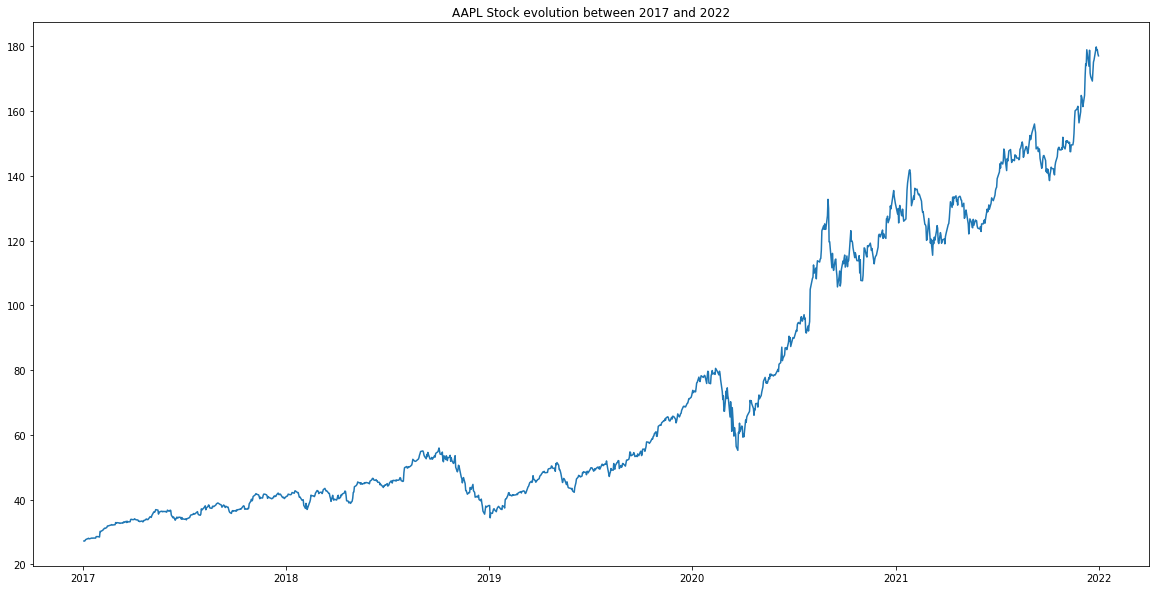

In [102]:
# Graphics of choosen Stock Price
plt.figure(figsize=(20,10))
plt.title(company+' Stock evolution between 2017 and 2022')
plt.plot(df['Date'],df['Close'])

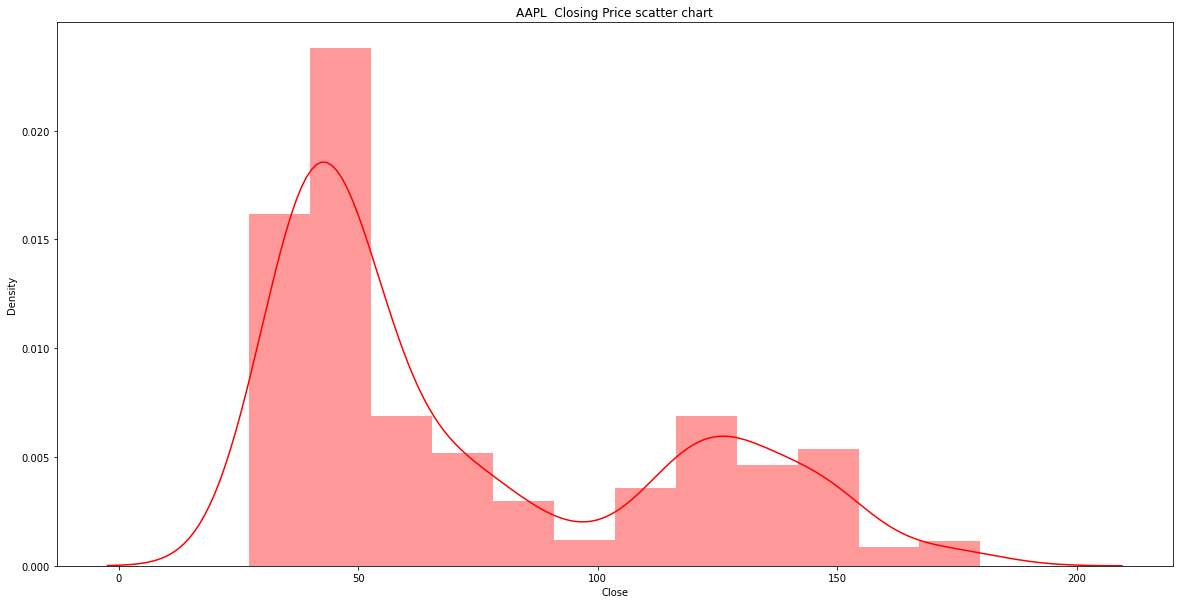

In [103]:
plt.figure(figsize=(20,10))
plt.title(company+'  Closing Price scatter chart')
sns.distplot(df['Close'], color='r')

In [104]:
#2017-2022 Candlestick Graphic of choosen Stock Prices

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.show()


# Date Range of choosen Stock Prices
df['Date'].min(), df['Date'].max() 

(Timestamp('2017-01-03 00:00:00'), Timestamp('2021-12-31 00:00:00'))

# Prophet Algorithm

**Rename Columns for Prophet**


In [105]:
df_prophet = df[['Date', 'Close']].rename(columns={'Date':'ds', 'Close':'y'}) # Change the data into a format that Prophet accepts
df_prophet.head()

,ds,y
0,2017-01-03,27.257643
1,2017-01-04,27.227137
2,2017-01-05,27.365593
3,2017-01-06,27.670673
4,2017-01-09,27.924128


**Train from "start_date" and Calculate Prediction Time**

In [106]:
start_date = df_prophet.iloc[TRAIN_SIZE]['ds']
print(" History : "+str(start_date)+"'from (%d. day), %d daily forecast" % (
         TRAIN_SIZE, H))

 History : 2019-01-03 00:00:00'from (503. day), 21 daily forecast


In [107]:
m = Prophet()
m.fit(df_prophet) 
df_cv = cross_validation(m, initial='1000 days',horizon='21 days', period='5 days', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_r = r2_calc(df_cv['y'],df_cv['yhat'])
rmses_parameters=df_p['rmse'].values[0]
mses_parameters=df_p['mse'].values[0]
maes_parameters=df_p['mae'].values[0]
mapes_parameters=df_p['mape'].values[0]
r2_parameters=df_r
print(df_cv)

print('/n')
print('Rmses:{0} ' .format(rmses_parameters))
print('MSES:{0}  '.format(mses_parameters))
print('Maes:{0} ' .format(maes_parameters))
print('R2:{0} '  .format(r2_parameters))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 161 forecasts with cutoffs between 2019-10-02 00:00:00 and 2021-12-10 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f18a95f3d90>


             ds        yhat  yhat_lower  yhat_upper           y     cutoff
0    2019-10-03   52.969310   51.202709   54.858868   54.085678 2019-10-02
1    2019-10-04   52.854194   50.950270   54.735848   55.601814 2019-10-02
2    2019-10-07   52.703432   50.949122   54.482623   55.614056 2019-10-02
3    2019-10-08   52.817567   50.987620   54.783451   54.962536 2019-10-02
4    2019-10-09   52.897544   51.077216   54.633980   55.606705 2019-10-02
...         ...         ...         ...         ...         ...        ...
2327 2021-12-27  159.076064  154.331469  163.770452  179.836319 2021-12-10
2328 2021-12-28  159.319483  154.401853  164.068585  178.799149 2021-12-10
2329 2021-12-29  159.380357  154.262484  164.407360  178.888916 2021-12-10
2330 2021-12-30  159.400812  154.201435  164.788577  177.712143 2021-12-10
2331 2021-12-31  159.331297  154.273653  164.330533  177.083878 2021-12-10

[2332 rows x 6 columns]
/n
Rmses:9.5980712635546 
MSES:92.1229719802726  
Maes:7.573958195503617 
R

## First Prediction

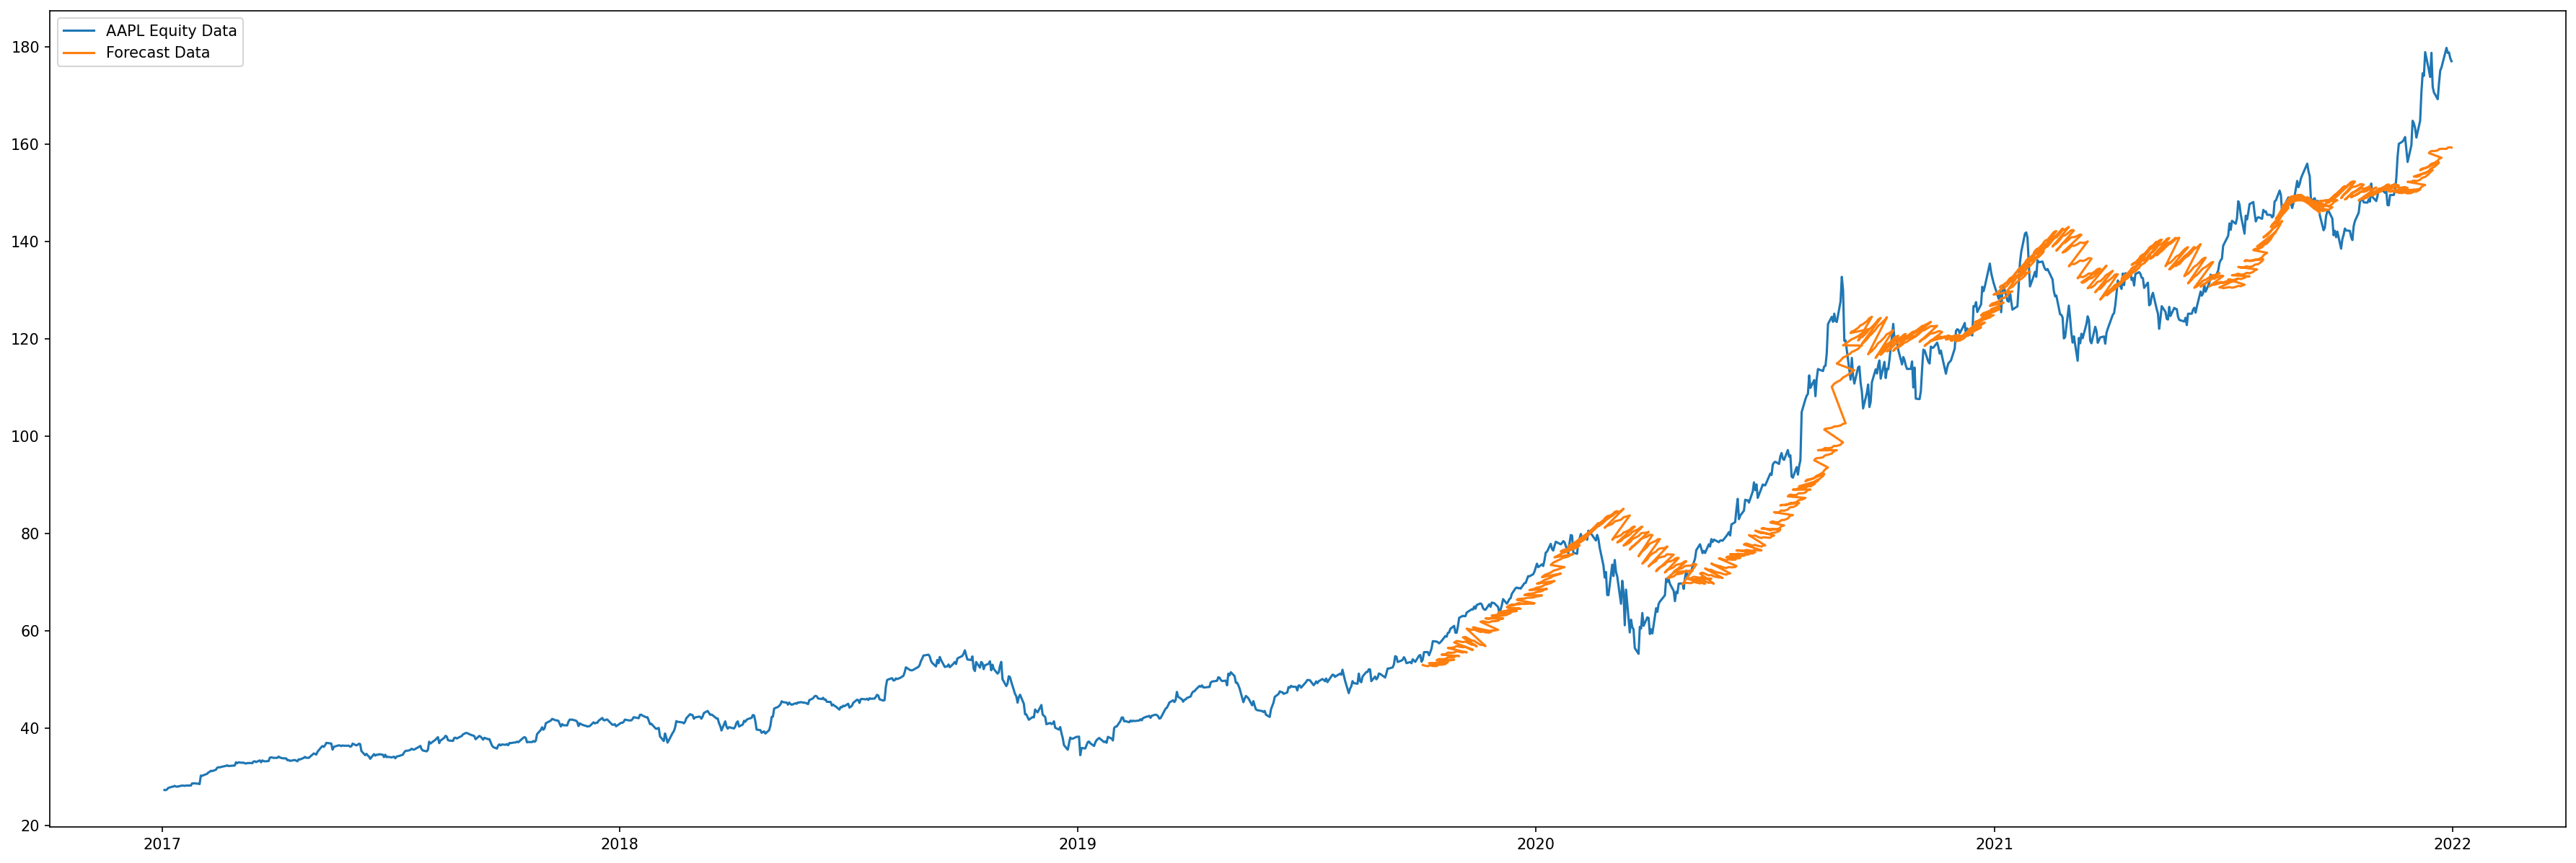

In [108]:

plt.figure(figsize=[30,10],dpi=150)
plt.plot(df['Date'],df['Close'])
plt.plot(df_cv['ds'],df_cv['yhat'])
plt.legend([company+' Equity Data','Forecast Data'])
plt.savefig(fname="Forecasting.png")

## Fitting Model


In [109]:
# Prophet Model Fitting
m = Prophet()
m.fit(df_prophet[0:TRAIN_SIZE])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Remove Weekend 

In [110]:
future = m.make_future_dataframe(periods=H)

In [111]:
# Remove weekends from future prediction 
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]
print(future.head(10))
future.to_csv('Future.csv')
# Prediction /Estimation of lower bound and upper bound
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.to_csv('Forecast.csv')


          ds  day
0 2017-01-03    1
1 2017-01-04    2
2 2017-01-05    3
3 2017-01-06    4
4 2017-01-09    0
5 2017-01-10    1
6 2017-01-11    2
7 2017-01-12    3
8 2017-01-13    4
9 2017-01-17    1


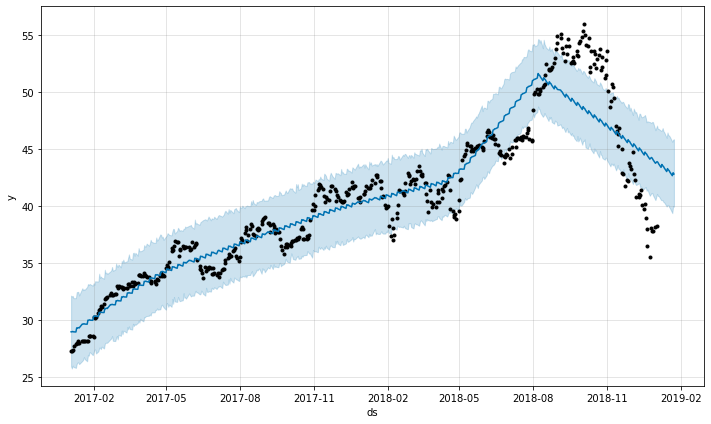

In [112]:
m.plot(forecast);

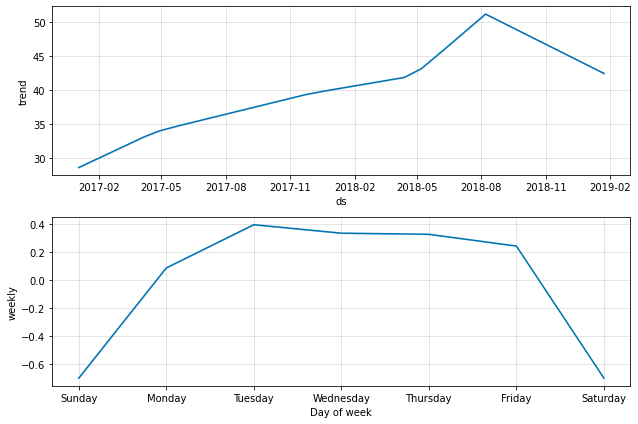

In [113]:
# Drawing Components
m.plot_components(forecast);

## Prophet Calculate Error Mertics 

In [114]:
prediction_list = forecast['yhat'][TRAIN_SIZE:len(future)]
print(len(prediction_list))

print(len(df_prophet[TRAIN_SIZE:len(future)]['y']))

print(len(future))
#deger = rmse_calc(df_prophet[TRAIN_SIZE:len(future)]['y'], prediction_list)


print("%s from the date (%d. day) , %d RMSE of the daily forecast %f" % ( df['Date'][TRAIN_SIZE].strftime("%m/%d/%Y"),TRAIN_SIZE,len(future)-TRAIN_SIZE, rmse_calc(df_prophet[TRAIN_SIZE:len(future)]['y'], prediction_list)))
print("%s from the date (%d. day) , %d average MAPE value of the daily forecast %f" % (df['Date'][TRAIN_SIZE].strftime("%m/%d/%Y"),TRAIN_SIZE,len(future)-TRAIN_SIZE, mape_calc(df_prophet[TRAIN_SIZE:len(future)]['y'], prediction_list)))
print("%s from the date (%d. day) , %d average MAE value of the daily forecast %f" % (df['Date'][TRAIN_SIZE].strftime("%m/%d/%Y"),TRAIN_SIZE,len(future)-TRAIN_SIZE, mae_calc(df_prophet[TRAIN_SIZE:len(future)]['y'], prediction_list)))
print("%s from the date (%d. day) , %d average r² value of the daily forecast %f" % (df['Date'][TRAIN_SIZE].strftime("%m/%d/%Y"),TRAIN_SIZE,len(future)-TRAIN_SIZE, r2_calc( df_prophet[TRAIN_SIZE:len(future)]['y'], prediction_list )))

15
15
518
01/03/2019 from the date (503. day) , 15 RMSE of the daily forecast 6.554938
01/03/2019 from the date (503. day) , 15 average MAPE value of the daily forecast 17.651879
01/03/2019 from the date (503. day) , 15 average MAE value of the daily forecast 6.461831
01/03/2019 from the date (503. day) , 15 average r² value of the daily forecast -56.565761


(737791.0, 738156.0)

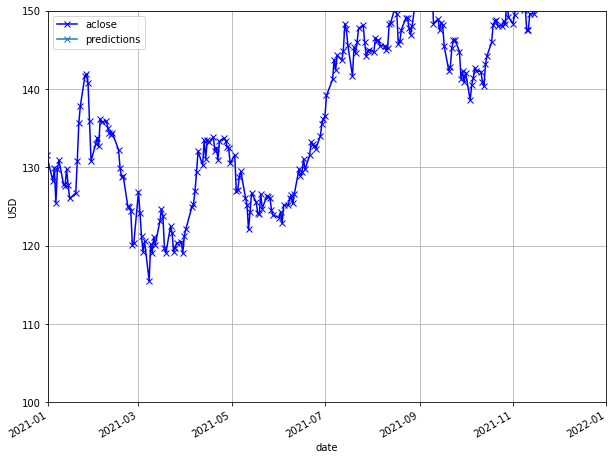

In [115]:
# Plotting forecasts
rcParams['figure.figsize'] = 10, 8 

ax = df.plot(x='Date', y='Close', style='bx-', grid=True)

ax.plot(df['Date'][TRAIN_SIZE:len(future)], prediction_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['aclose', 'predictions'])
ax.set_ylim([100, 150])
ax.set_xlim([date(2021, 1, 1), date(2022, 1, 1)])

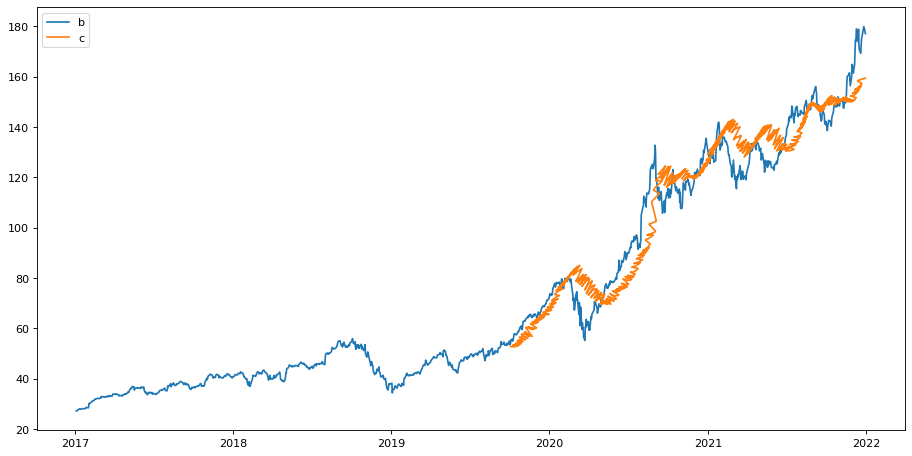

In [116]:
plt.figure(figsize=[14,7],dpi=80)
plt.plot(df['Date'],df['Close'])
plt.plot(df_cv['ds'],df_cv['yhat'])
plt.legend(['b','c'])
plt.savefig(fname="Forecasting.png")


# ARIMA

## ARIMA Prediction

In [117]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:

from pmdarima import auto_arima # a statistical librarydesigned to fill the void in Python’s time-series analysis capabilities, which is the equivalent of R’s auto.arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [119]:
stocks = yf.Ticker(company)
df=stocks.history(start='2017-01-01', end='2022-01-01', actions=False)
df = df.reset_index()
df.head(5)

,Date,Open,High,Low,Close,Volume
0,2017-01-03,27.175512,27.299890,26.931449,27.257648,115127600
1,2017-01-04,27.187244,27.342131,27.163777,27.227139,84472400
2,2017-01-05,27.203670,27.424266,27.177855,27.365597,88774400
3,2017-01-06,27.405488,27.729342,27.332739,27.670673,127007600
4,2017-01-09,27.680058,28.027380,27.677713,27.924122,134247600


In [120]:
df.describe()

,Open,High,Low,Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,73.284078,74.088129,72.523067,73.346268,1.209931e+08
std,41.017043,41.514839,40.525944,41.045797,5.615561e+07
min,27.175512,27.299890,26.931449,27.227139,4.100000e+07
25%,41.278418,41.624637,41.022947,41.293154,8.372580e+07
50%,52.374050,52.998742,51.805370,52.183510,1.062040e+08
75%,114.797884,116.246286,113.096975,114.557945,1.409942e+08
max,180.624141,181.631386,178.041235,179.836319,4.479400e+08


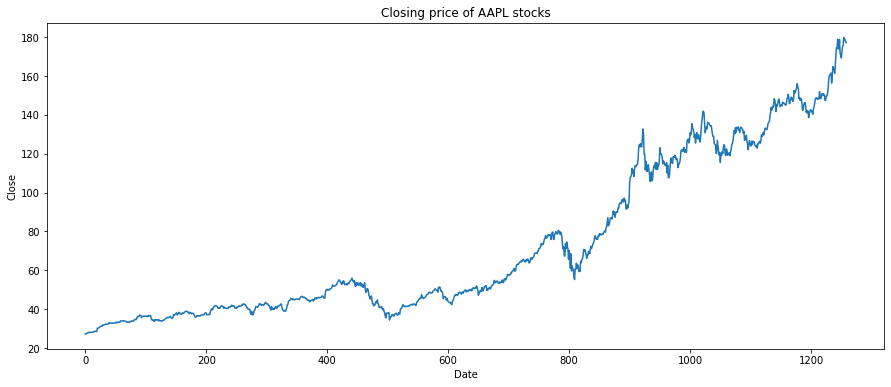

In [121]:
df["Close"].plot(figsize=(15, 6))
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Closing price of "+company+" stocks")
plt.show()

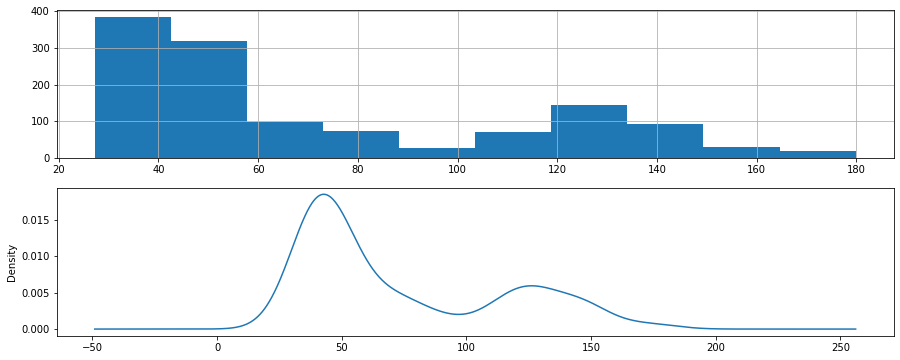

In [122]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Close"].hist()
plt.subplot(212)
df["Close"].plot(kind='kde')
plt.show()

In [123]:
#Define the time-series evaluation function
def timeseries_evaluation_metrics_func(y_true, y_pred):
 def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 print('Evaluation metric results:-')
 print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
 print(f'MSE is : {metrics.mean_absolute_error(y_true, y_pred)}')
 print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
 print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
 print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')


In [124]:
#ADF test function to check for stationary data
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [125]:
Augmented_Dickey_Fuller_Test_func(df['Close' ],'Close')

Results of Dickey-Fuller Test for column: Close
Test Statistic                    1.203488
p-value                           0.996010
No Lags Used                     20.000000
Number of Observations Used    1238.000000
Critical Value (1%)              -3.435643
Critical Value (5%)              -2.863877
Critical Value (10%)             -2.568014
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


We can see that Close is nonstationary, and auto-arima handles this
internally.

Model training will be done only for the Close column from the
dataset.let’s perform the test/train split.
The train will have all the data except the last 30 days, and the test will
contain only the last 30 days to evaluate against predictions.

In [126]:
X = df[['Close' ]]
train, test = X[0:-30], X[-30:]

The pmdarima module will help us identify p, d, and q without the
inconvenient of looking at the plot

In [127]:
stepwise_model = auto_arima(train,
                            start_p=1, 
                            start_q=1,
                            max_p=7, 
                            max_q=7, 
                            seasonal=False,
                            d=None, 
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4552.648, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4564.272, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4551.739, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4552.354, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4567.629, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4553.216, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4554.574, Time=0.75 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4556.346, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.967 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1229
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2272.869
Date:                Fri, 01 Jul 2022   AIC                           4551.739
Time:                        05:17:10   BIC                           4567.078
Sample:                             0   HQIC                          4557.510
                               - 1229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1134      0.044      2.571      0.010       0.027       0.200
ar.L1         -0.1085      0.017     -6.464      0.000      -0.141      -0.076
sigma2         2.3723      0.044     53.643      0.000       2.286       2.459
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2848.98
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              19.44   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto-arima says SARIMAX(1, 1, 0) is the optimal selection for the dataset.

In [128]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])
df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = range(1229, 1259)
df_conf = df_conf.set_index("new_index")

In [129]:
timeseries_evaluation_metrics_func(test, forecast)


Evaluation metric results:-
MSE is : 276.2365985623073
MSE is : 15.222773472577403
RMSE is : 16.620366980374026
MAPE is : 8.816356891242535
R2 is : -3.991852002671382



In [130]:
forecast["new_index"] = range(1229, 1259)
forecast = forecast.set_index("new_index")


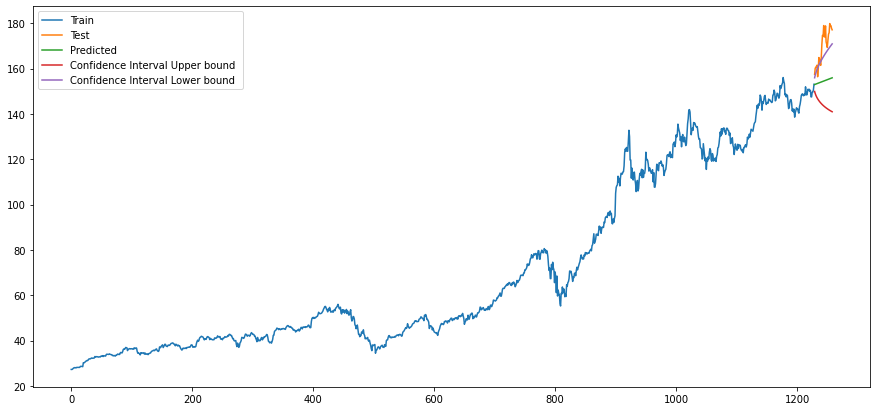

In [131]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

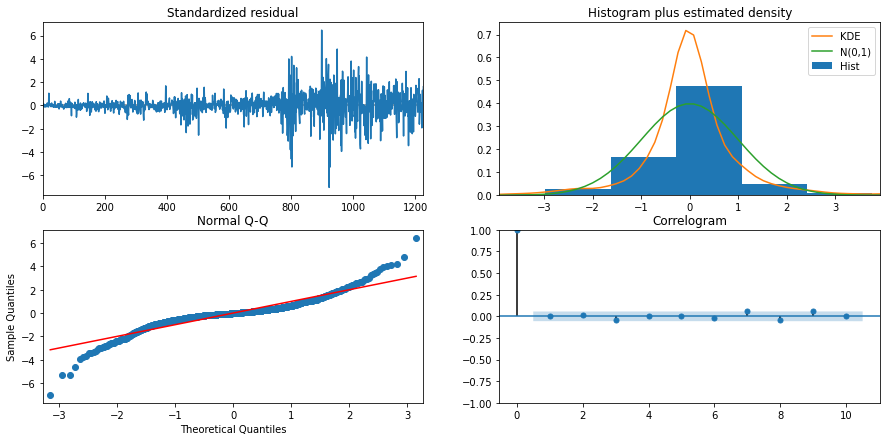

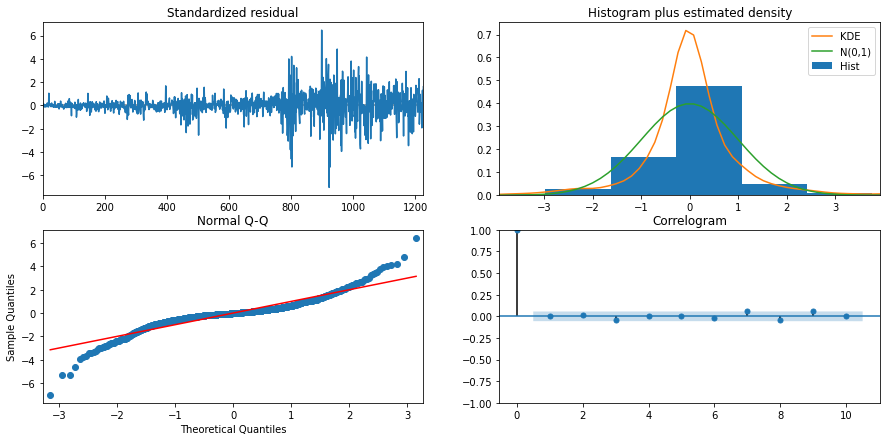

In [132]:
stepwise_model.plot_diagnostics()

# LSTM Algorithm

## LSTM Imports


In [133]:

stocks = yf.Ticker(company)
df=stocks.history(start='2017-01-01', end='2022-01-01', actions=False)
df = df.reset_index()
training_dataset = df
training_dataset

,Date,Open,High,Low,Close,Volume
0,2017-01-03,27.175506,27.299885,26.931443,27.257643,115127600
1,2017-01-04,27.187236,27.342124,27.163769,27.227131,84472400
2,2017-01-05,27.203664,27.424260,27.177849,27.365591,88774400
3,2017-01-06,27.405490,27.729344,27.332741,27.670675,127007600
4,2017-01-09,27.680056,28.027378,27.677711,27.924120,134247600
...,...,...,...,...,...,...
1254,2021-12-27,176.605184,179.926069,176.585249,179.836319,74919600
1255,2021-12-28,179.666792,180.833588,178.041250,178.799164,79144300
1256,2021-12-29,178.839050,180.135494,177.652305,178.888916,62348900
1257,2021-12-30,178.978670,180.075665,177.602443,177.712143,59773000


In [134]:
#Checking for null values and returning respective totals
print (training_dataset.isnull().sum())
total_null = training_dataset.isnull().sum().sum()
print ("The total number of null values is: " + str(total_null))

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
The total number of null values is: 0


In [135]:
#Drop every column except the open, high and low columns

training_dataset.drop(['Date', 'Close', 'Volume'], axis = 1, inplace = True)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f188299ae10>,
      dtype=object)

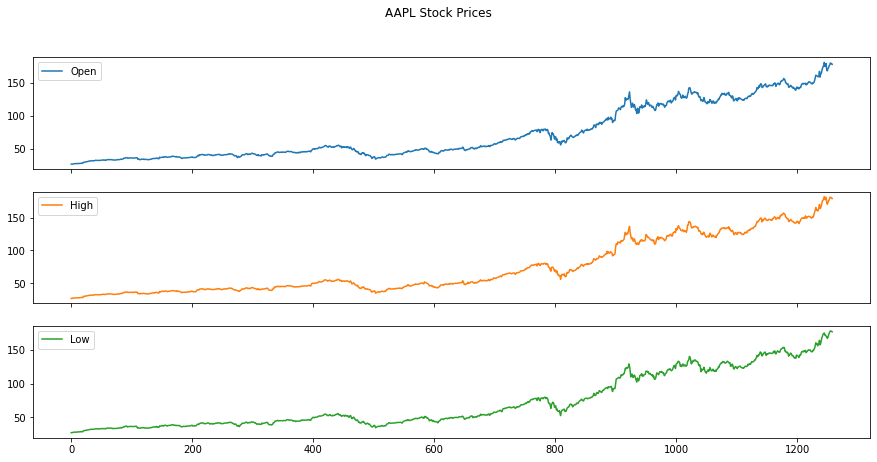

In [136]:
#Visualize the stock price data
training_dataset.plot.line(subplots = True, title=company+' Stock Prices')

In [137]:
#Drop the high and low columns 
training_dataset.drop(['High','Low'], axis = 1, inplace = True)
#Drop the bottom 2 columns
training_dataset.drop(training_dataset.tail(2).index,inplace=True)
print(training_dataset)
print(training_dataset.shape)

            Open
0      27.175506
1      27.187236
2      27.203664
3      27.405490
4      27.680056
...          ...
1252  172.566261
1253  175.368578
1254  176.605184
1255  179.666792
1256  178.839050

[1257 rows x 1 columns]
(1257, 1)


In [138]:
#Convert the data into numpy array
train_data = training_dataset.to_numpy()
train_data

array([[ 27.17550643],
       [ 27.18723637],
       [ 27.2036639 ],
       ...,
       [176.60518352],
       [179.66679243],
       [178.83904986]])

In [139]:
# separate the dataset into training and testing data with 80/20  
dataset_train = np.array(train_data[:int(train_data.shape[0]*0.8)])
dataset_test = np.array(train_data[int(train_data.shape[0]*0.8):])
#Find number of columns for each dataset
print(dataset_train.shape)
print(dataset_test.shape)

(1005, 1)
(252, 1)


In [140]:
#Scale the data to range[0,1]
#MinMaxScalar subtracts the minimum value in each feature and divides by the range (the difference between original min and max)
scalar = MinMaxScaler(feature_range = (0,1))
train_data = scalar.fit_transform(dataset_train)
train_data.shape

(1005, 1)

In [141]:
#Declare the x_train and y_train 
x_train = train_data[0:1004]
y_train = train_data[1:1005]

x_train = np.reshape(x_train, (1004,1,1))
x_train.shape

(1004, 1, 1)

In [142]:
#Instantiate the Sequential model class 
model = Sequential()
#Set the number of neurons with the units parameter

#Return_sequences=True reflects adding more layers

model.add(LSTM(units=96, return_sequences=True, input_shape=(None, 1)))

#Add dropout to reduce overfitting
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))

#Add dense layer to reduce spacial parameters of the vector
model.add(Dense(units=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 96)          37632     
                                                                 
 dropout_4 (Dropout)         (None, None, 96)          0         
                                                                 
 lstm_5 (LSTM)               (None, None, 96)          74112     
                                                                 
 dropout_5 (Dropout)         (None, None, 96)          0         
                                                                 
 lstm_6 (LSTM)               (None, None, 96)          74112     
                                                                 
 dropout_6 (Dropout)         (None, None, 96)          0         
                                                                 
 lstm_7 (LSTM)               (None, 96)               

In [143]:
#Compile the model
model.compile(optimizer = 'adam', loss = "mean_squared_error")

In [144]:
#Train the model for 100 epochs with 32 training examples used in each iteration
model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
32/32 [==============================] - 5s 7ms/step - loss: 0.0830
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0323
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 8/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 9/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 10/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 11/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 12/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 13/100
32/32 [=================

In [145]:
#Display the testing dataset
print(dataset_test)
print(dataset_test.shape)

[[134.38039335]
 [132.89366136]
 [132.3386352 ]
 [127.7496075 ]
 [126.58993611]
 [127.22426536]
 [131.25826509]
 [128.04694713]
 [127.3630365 ]
 [127.62072917]
 [129.64270136]
 [127.64055677]
 [126.64940635]
 [127.52163852]
 [132.6161672 ]
 [135.07420062]
 [141.80413843]
 [142.32945042]
 [142.16092825]
 [138.28553674]
 [134.62817268]
 [132.56657634]
 [134.52906663]
 [134.5587868 ]
 [135.09402535]
 [136.3381675 ]
 [135.02789091]
 [135.61353294]
 [135.47455982]
 [134.8988381 ]
 [133.36025167]
 [134.49187589]
 [130.28311241]
 [128.24820295]
 [129.28055363]
 [127.06697228]
 [122.84828734]
 [124.01959902]
 [123.76149721]
 [121.68690328]
 [122.83836311]
 [127.46403695]
 [123.89053822]
 [120.85308644]
 [120.08875927]
 [120.03913342]
 [118.15312277]
 [120.79353991]
 [121.63726008]
 [119.51304102]
 [120.51558858]
 [124.77398282]
 [123.13614325]
 [121.97476102]
 [119.01671524]
 [119.44355526]
 [122.42144917]
 [121.91520654]
 [118.65936936]
 [119.46339727]
 [120.75382955]
 [119.22516806]
 [120.75

In [146]:
inputs = np.reshape(scalar.transform(dataset_test), (252,1,1)) #Reshaping the training data then scaling it
stock_pred = scalar.inverse_transform(model.predict(inputs)) #Reverse the predictions scaled , to their original values  
stock_pred

array([[128.38583 ],
       [127.73914 ],
       [127.48449 ],
       [125.11094 ],
       [124.43761 ],
       [124.80948 ],
       [126.96845 ],
       [125.27891 ],
       [124.88969 ],
       [125.037544],
       [126.147224],
       [125.04887 ],
       [124.472824],
       [124.980865],
       [127.612724],
       [128.66982 ],
       [130.8211  ],
       [130.94221 ],
       [130.9041  ],
       [129.83408 ],
       [128.48857 ],
       [127.58994 ],
       [128.44766 ],
       [128.45995 ],
       [128.67776 ],
       [129.15768 ],
       [128.65121 ],
       [128.88268 ],
       [128.82849 ],
       [128.5991  ],
       [127.947685],
       [128.43225 ],
       [126.479805],
       [125.39151 ],
       [125.95511 ],
       [124.71807 ],
       [122.07298 ],
       [122.84404 ],
       [122.67651 ],
       [121.28159 ],
       [122.06633 ],
       [124.94782 ],
       [122.76044 ],
       [120.69728 ],
       [120.15008 ],
       [120.11417 ],
       [118.71598 ],
       [120.6

In [147]:
stock_pred = np.squeeze(stock_pred)
stock_pred

array([128.38583 , 127.73914 , 127.48449 , 125.11094 , 124.43761 ,
       124.80948 , 126.96845 , 125.27891 , 124.88969 , 125.037544,
       126.147224, 125.04887 , 124.472824, 124.980865, 127.612724,
       128.66982 , 130.8211  , 130.94221 , 130.9041  , 129.83408 ,
       128.48857 , 127.58994 , 128.44766 , 128.45995 , 128.67776 ,
       129.15768 , 128.65121 , 128.88268 , 128.82849 , 128.5991  ,
       127.947685, 128.43225 , 126.479805, 125.39151 , 125.95511 ,
       124.71807 , 122.07298 , 122.84404 , 122.67651 , 121.28159 ,
       122.06633 , 124.94782 , 122.76044 , 120.69728 , 120.15008 ,
       120.11417 , 118.71598 , 120.655045, 121.24717 , 119.73068 ,
       120.45701 , 123.32594 , 122.265015, 121.480194, 119.364235,
       119.67965 , 121.78521 , 121.43924 , 119.097626, 119.69424 ,
       120.62684 , 119.518684, 120.62684 , 122.00638 , 122.14601 ,
       123.82056 , 123.4072  , 125.25255 , 125.71953 , 127.107414,
       127.06895 , 128.20222 , 127.71219 , 127.92573 , 127.571

In [148]:
stock_pred = stock_pred.reshape(-1,1)
stock_pred

array([[128.38583 ],
       [127.73914 ],
       [127.48449 ],
       [125.11094 ],
       [124.43761 ],
       [124.80948 ],
       [126.96845 ],
       [125.27891 ],
       [124.88969 ],
       [125.037544],
       [126.147224],
       [125.04887 ],
       [124.472824],
       [124.980865],
       [127.612724],
       [128.66982 ],
       [130.8211  ],
       [130.94221 ],
       [130.9041  ],
       [129.83408 ],
       [128.48857 ],
       [127.58994 ],
       [128.44766 ],
       [128.45995 ],
       [128.67776 ],
       [129.15768 ],
       [128.65121 ],
       [128.88268 ],
       [128.82849 ],
       [128.5991  ],
       [127.947685],
       [128.43225 ],
       [126.479805],
       [125.39151 ],
       [125.95511 ],
       [124.71807 ],
       [122.07298 ],
       [122.84404 ],
       [122.67651 ],
       [121.28159 ],
       [122.06633 ],
       [124.94782 ],
       [122.76044 ],
       [120.69728 ],
       [120.15008 ],
       [120.11417 ],
       [118.71598 ],
       [120.6

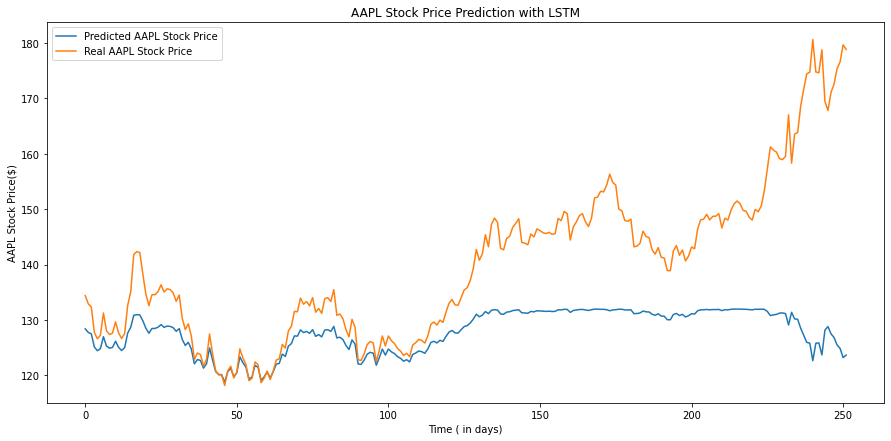

In [149]:
#Plot the real stock prices against the prediction of the model
plt.plot(stock_pred, label = 'Predicted '+company+' Stock Price', linewidth = 1.5)
plt.plot(dataset_test, label = 'Real '+company+' Stock Price', linewidth = 1.5)
plt.title(company+" Stock Price Prediction with LSTM")
plt.xlabel('Time ( in days)')
plt.ylabel(company+' Stock Price($)')
plt.legend()
plt.show()

In [150]:
#Calculate the standard deviation of the residuals
rmse_value = math.sqrt(mean_squared_error(dataset_test, stock_pred))
rmse_value = round(rmse_value, 3)
print(rmse_value)

17.116


In [151]:
#Extrapolate the minimum and maximum real stock price values
maxValTest = round(float(max(dataset_test)), 2)
minValTest = round(float(min(dataset_test)), 2)
print ("The real maximum stock price is: " + str(maxValTest) +" dollars")
print ("The real minimum stock price is: " + str(minValTest) + " dollars")

The real maximum stock price is: 180.62 dollars
The real minimum stock price is: 118.15 dollars


In [ ]:
#Calculate error and model accuracy with MAPE
total = 0
for i, j in zip(dataset_test, stock_pred):
    value = abs(i - j) / abs(i)
    total += value
error = float(total*100/(len(dataset_test))) #calculate mape
mape = round(error, 1) #round to 3 significant figures
accuracy = 100 - mape #Calculate accuracy
print ("The LSTM's accuracy in predicting the stock price is: " + str(accuracy) + "%")

In [152]:
#Extrapolate the minimum and maximum real stock price values
maxValPredict = round(float(max(stock_pred)), 2)
minValPredict = round(float(min(stock_pred)), 2)
print ("The predicted maximum stock price is: " + str(maxValPredict) +" dollars")
print ("The predicted minimum stock price is: " + str(minValPredict) +" dollars")

The predicted maximum stock price is: 131.95 dollars
The predicted minimum stock price is: 118.72 dollars


# Linear Regresssion



In [175]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [176]:
# Data Preprocessing :
# load data
company="AAPL"
stocks = yf.Ticker(company)
df=stocks.history(start='2017-01-01', end='2021-12-31', actions=False)
df = df.reset_index()

In [177]:
pd.set_option('display.max_columns', None)
# show the first 5 entries of the dataset
df.head()

,Date,Open,High,Low,Close,Volume
0,2017-01-03,27.175505,27.299883,26.931441,27.257641,115127600
1,2017-01-04,27.187242,27.342129,27.163775,27.227137,84472400
2,2017-01-05,27.203670,27.424266,27.177855,27.365597,88774400
3,2017-01-06,27.405492,27.729346,27.332743,27.670677,127007600
4,2017-01-09,27.680060,28.027382,27.677715,27.924124,134247600


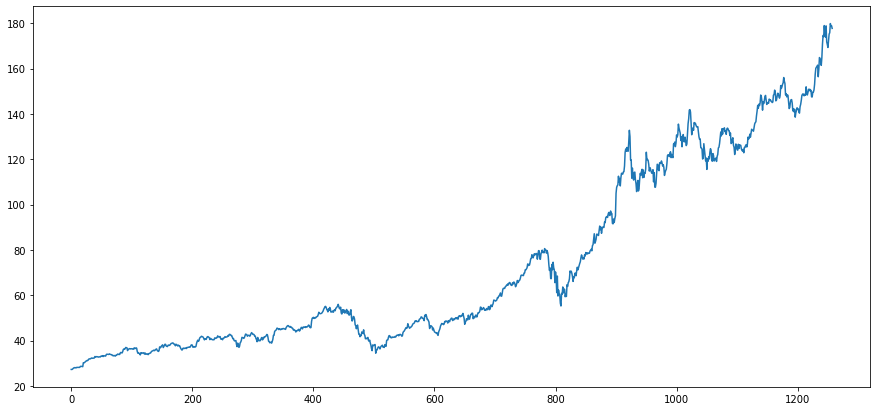

In [178]:
# Closing Price
df1 = df['Close']
df['Close'].plot()

In [179]:
# Scaling Data:
df1 = np.array(df1)
df1 = df1.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(df1)
print(df1)

[[1.99884609e-04]
 [0.00000000e+00]
 [9.07285900e-04]
 ...
 [9.93203848e-01]
 [9.93791966e-01]
 [9.86080942e-01]]


In [180]:
# Splitting Data into Training and Testing Set:
df1.shape

(1258, 1)

In [181]:
# splitting dataset into train and test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data  =df1[0:training_size,:], df1[training_size:len(df1),:1]
train_data.shape
test_data.shape
training_size, test_size
train_data[:10]

array([[0.00019988],
       [0.        ],
       [0.00090729],
       [0.00290638],
       [0.00456714],
       [0.00475165],
       [0.00573584],
       [0.00496693],
       [0.00464401],
       [0.00612026]])

In [182]:
# Converting Array of Matrix into a Dataset Matrix :
def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a= dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i+ time_step, 0])
        return np.array(dataX), np.array(dataY)

In [183]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
train_data.shape, test_data.shape

((817, 1), (441, 1))

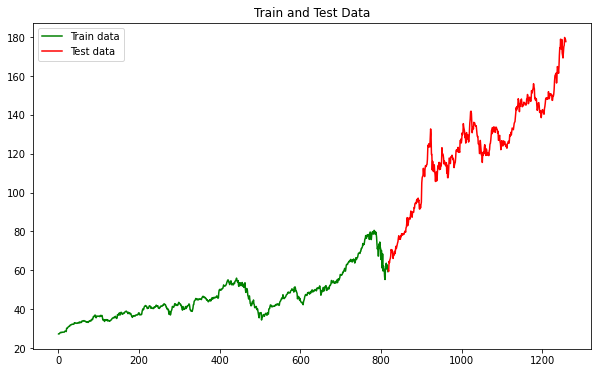

In [184]:
# A total of 817 + 441 = 1258
# allocate series of 817  from index 1 to 817
trainplot = np.arange(1,818)
# allocate series of 818 to 1258
testplot = np.arange(818,1259)

# Ploting Train and Test Data
plt.figure(figsize=(10,6))
plt.plot(trainplot,scaler.inverse_transform(train_data)[:,0], 'green', label='Train data')
plt.plot(testplot, scaler.inverse_transform(test_data)[:,0],'red', label='Test data')
plt.legend()
plt.title('Train and Test Data')
plt.show()

In [185]:
# Model Building (linear Regression) :
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [186]:
# Predictions and Model Evaluation :
predictions = model.predict(X_test)
print("Predicted Value",predictions[:10][0])
print("Expected Value",y_test[:10][0])

Predicted Value 0.6406939179527269
Expected Value 0.6308948040162845


In [187]:
pred_df= pd.DataFrame(predictions)
pred_df['TrueValues']=y_test

new_pred_df=pred_df.rename(columns={0: 'Predictions'})
new_pred_df.head()

,Predictions,TrueValues
0,0.640694,0.630895
1,0.642578,0.641901
2,0.647087,0.632094
3,0.635949,0.630781
4,0.640399,0.658223


Text(0.5, 1.0, 'Predictions Vs True Values on Testing Set')

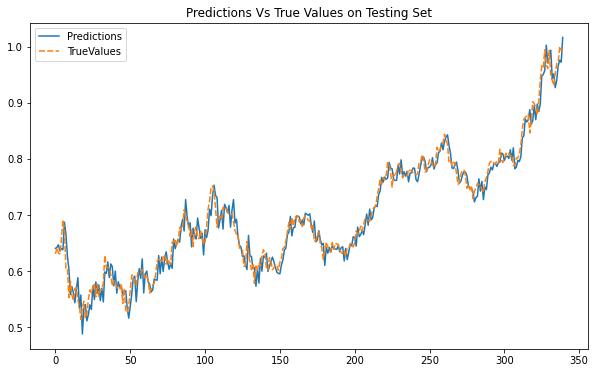

In [188]:
# Plot Predicted vs Actual Prices of Test Series :
plt.figure(figsize=(10,6))
sns.lineplot(data=new_pred_df)
plt.title("Predictions Vs True Values on Testing Set")

In [189]:
print("model Accuracy on training data:",model.score(X_train, y_train))

model Accuracy on training data: 0.9931540165249282


In [190]:
# Model accuracy on Testing data
print("model Accuracy is on training data:",model.score(X_test, y_test))

model Accuracy is on training data: 0.9675827055170314


In [191]:
# Lets Do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

In [192]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [193]:

# Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

49.133349597463784

In [194]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

134.07822731897187

# Random Forest

In [201]:
from subprocess import check_output
from matplotlib.pylab import rcParams

In [202]:
# Data Preprocessing :
# load data
company="AAPL"
stocks = yf.Ticker(company)
df=stocks.history(start='2017-01-01', end='2022-12-31', actions=False)
df = df.reset_index()

In [203]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
def create_dataset(dataset,past=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-past-1):
        j = dataset[i:(i+past), 0]
        dataX.append(j)
        dataY.append(dataset[i + past, 0])
    return np.array(dataX), np.array(dataY)
from sklearn.preprocessing import MinMaxScaler
def testandtrain(prices):
    scaler = MinMaxScaler(feature_range=(0, 1))
    prices = scaler.fit_transform(prices)
    trainsize = int(len(prices) * 0.80)
    testsize = len(prices) - trainsize
    train, test = prices[0:trainsize,:], prices[trainsize:len(prices),:]
    print(len(train), len(test))
    
    x_train,y_train = create_dataset(train,1)
    x_test,y_test = create_dataset(test,1)
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    #y_test =scaler.fit_transform(y_test)
    #y_train=scaler.fit_transform(y_train)
    return x_train,y_train, x_test,y_test
prices = df['Close'].values.astype('float32') 
# Obtaining the values of closing data each day and converting to float as Neural network can easily model float 
prices = prices.reshape(len(prices), 1)
prices.shape

(1383, 1)

In [204]:
trainX, trainY, testX, testY=testandtrain(prices)

1106 277


In [205]:
randomforest  = RandomForestRegressor(random_state=2017,verbose=2,n_jobs=5) #random forest algorithm
randomforest.fit(trainX,trainY)

building tree 1 of 100
building tree 2 of 100building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100building tree 10 of 100


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100building tree 25 of 100

building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.1s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100building tree 39 of 100
building tree 40 of 100
building tree 41 of 100

building tree 42 of 100building tree 43 of 100
building tree 44 of 100
building tree 45 of 100

building tree 46 of 100
building tree 47 of 100building tree 48 of 100
building tree 49 of 100

building tree 50 of 100building tree 51 of 100

building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100building tree 69 of 100
building tree 70 of 100

building tree 71 of 100
building tree 72 of 100building tree 73 of 100
building tree 74 of 100building tree 75 of 100
building tree 76 of 100building tree 77 of 

[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(n_jobs=5, random_state=2017, verbose=2)

In [206]:
test=[]
test= randomforest.predict(testX)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


In [207]:
testY

array([0.63091975, 0.6266018 , 0.62447506, 0.62950194, 0.61970603,
       0.6348511 , 0.63491553, 0.64032906, 0.6428425 , 0.6362689 ,
       0.6442603 , 0.66443217, 0.65901864, 0.6623055 , 0.67287475,
       0.66430336, 0.67616165, 0.68698865, 0.6851843 , 0.6833153 ,
       0.681382  , 0.6921445 , 0.7021337 , 0.7061941 , 0.7081919 ,
       0.7255282 , 0.7388043 , 0.75523823, 0.7466668 , 0.75871843,
       0.7547871 , 0.7621341 , 0.78475493, 0.78043705, 0.76696754,
       0.74157536, 0.76542085, 0.7605873 , 0.76960987, 0.7809525 ,
       0.78372383, 0.7694166 , 0.75788045, 0.7621341 , 0.7635519 ,
       0.7613609 , 0.7732189 , 0.7705767 , 0.7712856 , 0.76676744,
       0.76644474, 0.7632822 , 0.7649602 , 0.7845171 , 0.7858725 ,
       0.79891026, 0.7929078 , 0.76818746, 0.770382  , 0.779999  ,
       0.78980976, 0.7892287 , 0.78109616, 0.77580357, 0.7826453 ,
       0.811819  , 0.8034929 , 0.8078818 , 0.8152398 , 0.81943524,
       0.83486116, 0.82466316, 0.8179507 , 0.78503335, 0.78877

In [208]:
math.sqrt(mean_squared_error(test,testY))

0.43938013145896737

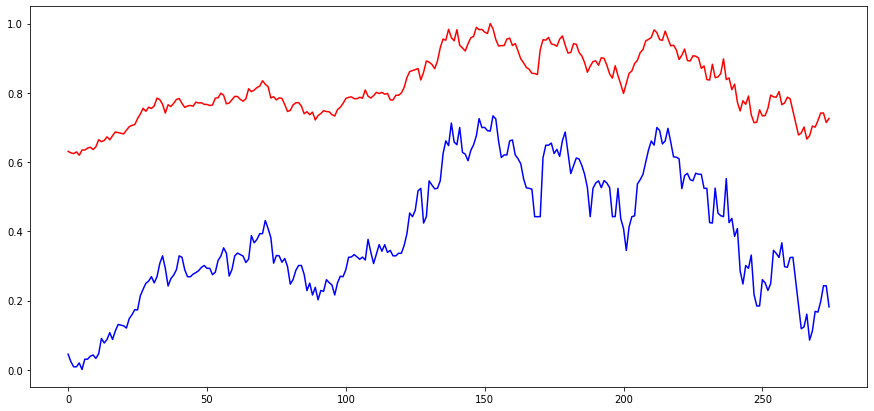

In [209]:
plt.plot(test,color="blue")
plt.plot(testY,color='red')
plt.show()

# AR models

In [264]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.regression.linear_model import OLS

In [265]:
stocks = yf.Ticker(company)
df=stocks.history(start='2017-01-01', end='2021-12-31', actions=False)
df = df.reset_index()

In [266]:
# Make stationarry
apple = df.Close.diff().fillna(0)

# Créer un décalage
apple_lag_1 = apple.shift(1).fillna(0)

Text(0.5, 1.0, 'APPLE Returns')

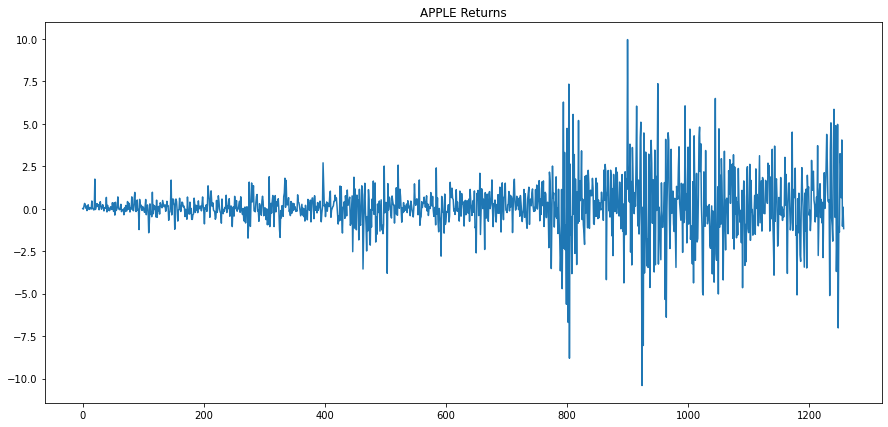

In [267]:
apple.plot()
plt.title("APPLE Returns")

In [268]:
# Put all in a dataframe

df_regression = pd.DataFrame(apple)
df_regression["Lag1"] = apple_lag_1

# Divide training/test
df_regression_train = df_regression.iloc[0:200]
df_regression_test = df_regression.iloc[200:]

In [269]:
#Slippy regression 
n = 0
rsquared = []

while n<=30:
    
    y = df_regression_train["Close"].iloc[-n:]
    x = df_regression_train["Lag1"].iloc[-n:]
    x = sm.add_constant(x)

    model = sm.OLS(y,x)
    results = model.fit()

    rsquared.append(results.rsquared)

    n +=1

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning:

invalid value encountered in double_scalars



Text(0.5, 0, 'Observation')

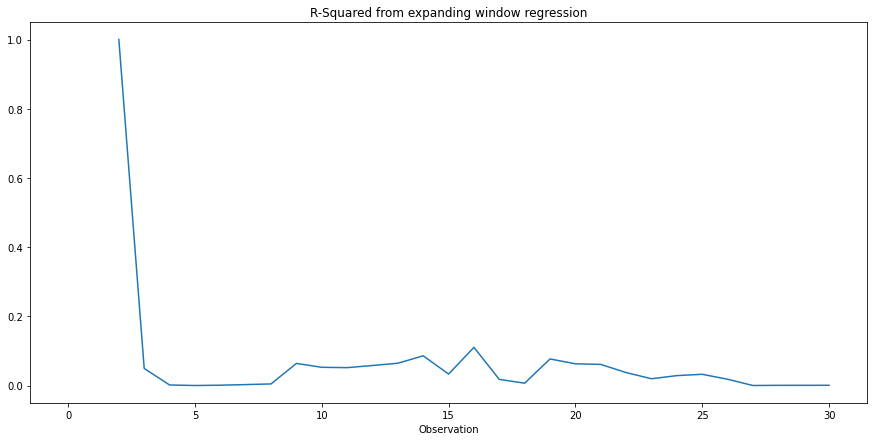

In [270]:
plt.plot(rsquared)
plt.title("R-Squared from expanding window regression")
plt.xlabel("Observation")

In [271]:
# Modèle AR(1) à coefficients statiques - données d'apprentissage
y = df_regression_train["Close"].iloc[-13:]
x = df_regression_train["Lag1"].iloc[-13:]
x = sm.add_constant(x)

In [272]:
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.7561
Date:                Fri, 01 Jul 2022   Prob (F-statistic):              0.403
Time:                        06:27:45   Log-Likelihood:                0.85636
No. Observations:                  13   AIC:                             2.287
Df Residuals:                      11   BIC:                             3.417
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1557      0.074      2.110      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=13



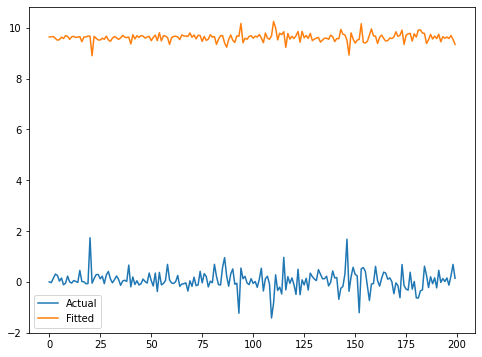

In [273]:
# Adjust model AR(1) to training data:
fitted = 9.6456 + -0.4268*df_regression_train["Lag1"]

ax = plt.figure(figsize=(8,6))
plt.plot(df_regression_train["Close"])
plt.plot(fitted)
plt.legend(["Actual","Fitted"])

Text(0.5, 1.0, 'Residuals')

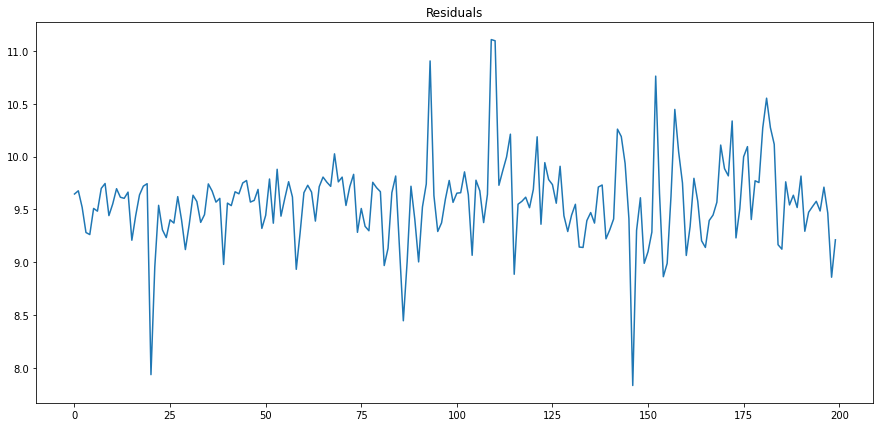

In [274]:
# Combine into 1 dataframe
df_2 = pd.DataFrame({"Fitted Value":fitted,
                        "Actual":df_regression_train["Close"]})
# Calculate residuals
df_2["Residuals"] = df_2["Fitted Value"] - df_2["Actual"]

df_2.Residuals.plot()
plt.title("Residuals")

In [275]:
# Calculate success rate training
true_neg = np.sum((df_2["Fitted Value"] <0) & (df_2["Actual"] <0))
true_pos = np.sum((df_2["Fitted Value"] >0) & (df_2["Actual"] >0))
accuracy = (true_neg + true_pos)/len(df_2)
accuracy

0.56

Text(0.5, 1.0, 'Actual vs Fitted - Test Data')

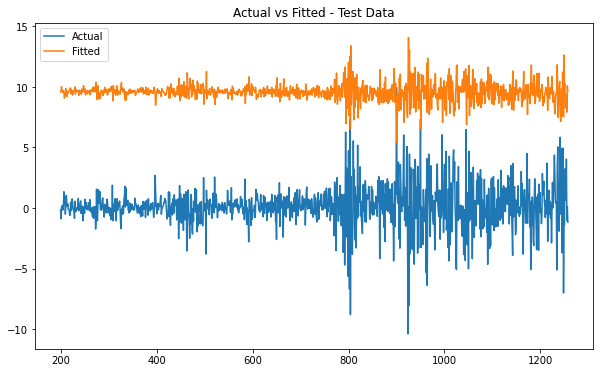

In [276]:
#Apply to test data
fitted_test = 9.6456 + -0.4268*df_regression_test["Lag1"]
ax = plt.figure(figsize=(10,6))

plt.plot(df_regression_test["Close"])
plt.plot(fitted_test)
plt.legend(["Actual","Fitted"])
plt.title("Actual vs Fitted - Test Data")

Text(0.5, 1.0, 'Residuals - Test Data')

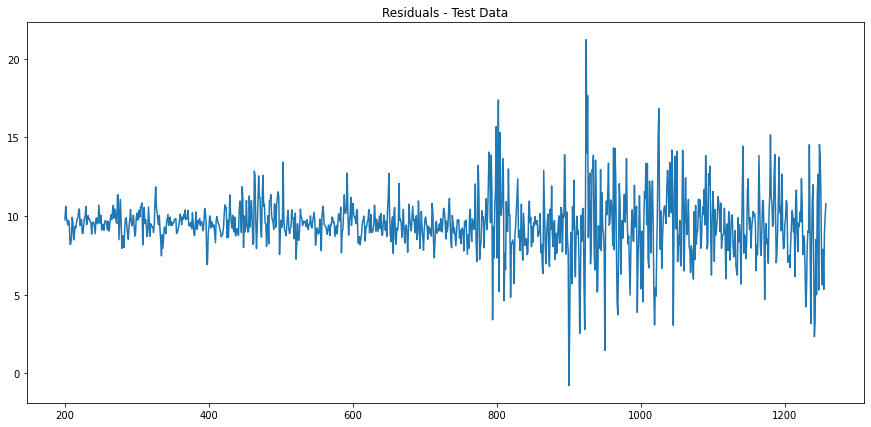

In [277]:
# Combine into 1 dataframe
df_2_test = pd.DataFrame({"Fitted Value":fitted_test,
                        "Actual":df_regression_test["Close"]})
# Calculate residuals
df_2_test["Residuals"] = df_2_test["Fitted Value"] - df_2_test["Actual"]
df_2_test["Residuals"].plot()
plt.title("Residuals - Test Data")